# OpenStreetMap Country Analysis

## Load Economic Measurements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

plt.style.use('ggplot')
%matplotlib inline

df_targets = pd.read_csv('data/economic_measurements.csv', index_col='country')
df_targets.drop(columns='country_code', inplace=True)
df_targets = df_targets[['Population', 'GNI', 'GDP', 'BM Dollar', 'HDI']]
df_targets.head()

,Population,GNI,GDP,BM Dollar,HDI
country,,,,,
Belgium,11338476.0,42367.993039,46428.671425,5.019425,0.895514
Bulgaria,7127822.0,17758.415202,19242.622616,NaN,0.793642
Czech Republic,10566332.0,29279.681889,34749.212363,3.807779,0.877842
Denmark,5728010.0,47160.293155,49029.014839,4.932020,0.924649
Germany,82487842.0,45126.504599,48860.525292,4.774575,0.925669


In [2]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Belgium to Switzerland
Data columns (total 5 columns):
Population    32 non-null float64
GNI           29 non-null float64
GDP           31 non-null float64
BM Dollar     21 non-null float64
HDI           32 non-null float64
dtypes: float64(5)
memory usage: 1.5+ KB


## Load and normalize collected OSM Counts

In [3]:
df_amenity = pd.read_csv('data/country_amenity_counts.csv')
df_amenity.set_index('country', inplace=True)
df_amenity.drop(columns='country_code', inplace=True)

# Replace 0 values with 0.1
df_amenity = df_amenity.applymap(lambda x: 0.1 if x == 0 else float(x))

# Normalize amenities    
df_amenity_normalized = df_amenity.apply(
    lambda row: row / df_targets['Population'].loc[row.name], axis=1)

df_amenity.head()

,parking,place_of_worship,school,bench,restaurant,fuel,cafe,fast_food,bank,waste_basket,...,waste_disposal,marketplace,bus_station,university,college,parking_entrance,swimming_pool,theatre,taxi,veterinary
country,,,,,,,,,,,,,,,,,,,,,
Belgium,33209.0,6644.0,5936.0,15257.0,7549.0,2414.0,2496.0,3441.0,2529.0,9439.0,...,80.0,124.0,79.0,520.0,248.0,430.0,408.0,333.0,79.0,370.0
Bulgaria,4978.0,1964.0,1686.0,372.0,2828.0,1437.0,1353.0,710.0,925.0,72.0,...,68.0,182.0,222.0,162.0,51.0,56.0,84.0,121.0,193.0,81.0
Czech Republic,29815.0,8010.0,3768.0,14759.0,10271.0,2580.0,2057.0,2069.0,1291.0,2424.0,...,335.0,98.0,444.0,280.0,487.0,352.0,118.0,374.0,65.0,290.0
Denmark,32094.0,2620.0,2249.0,4168.0,2840.0,1810.0,3067.0,6780.0,682.0,1122.0,...,100.0,49.0,219.0,181.0,126.0,263.0,18.0,178.0,131.0,65.0
Germany,403687.0,62159.0,38465.0,333044.0,94386.0,17898.0,28377.0,31867.0,25452.0,61599.0,...,2054.0,1494.0,1842.0,2624.0,1188.0,8359.0,120.0,2596.0,4054.0,3417.0


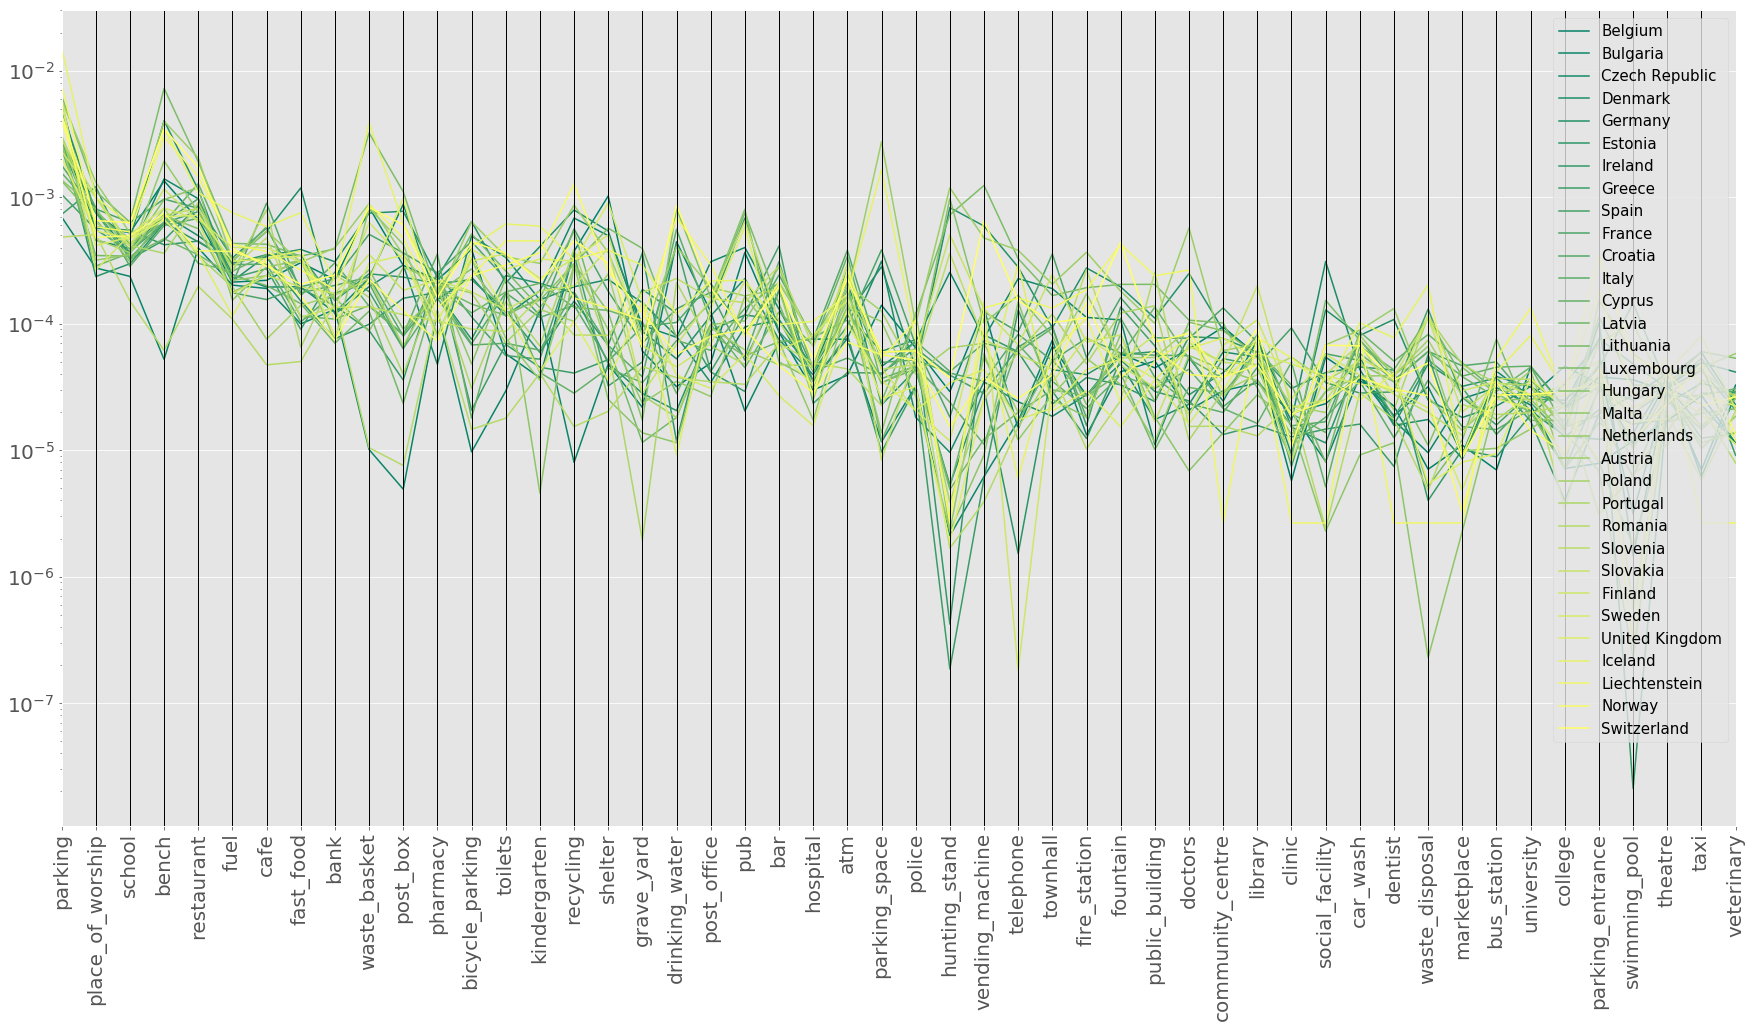

In [4]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(30, 15))
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
ax = parallel_coordinates(df_amenity_normalized.reset_index(), 'country', colormap='summer')
ax.set_yscale('log')
plt.legend(fontsize=15);

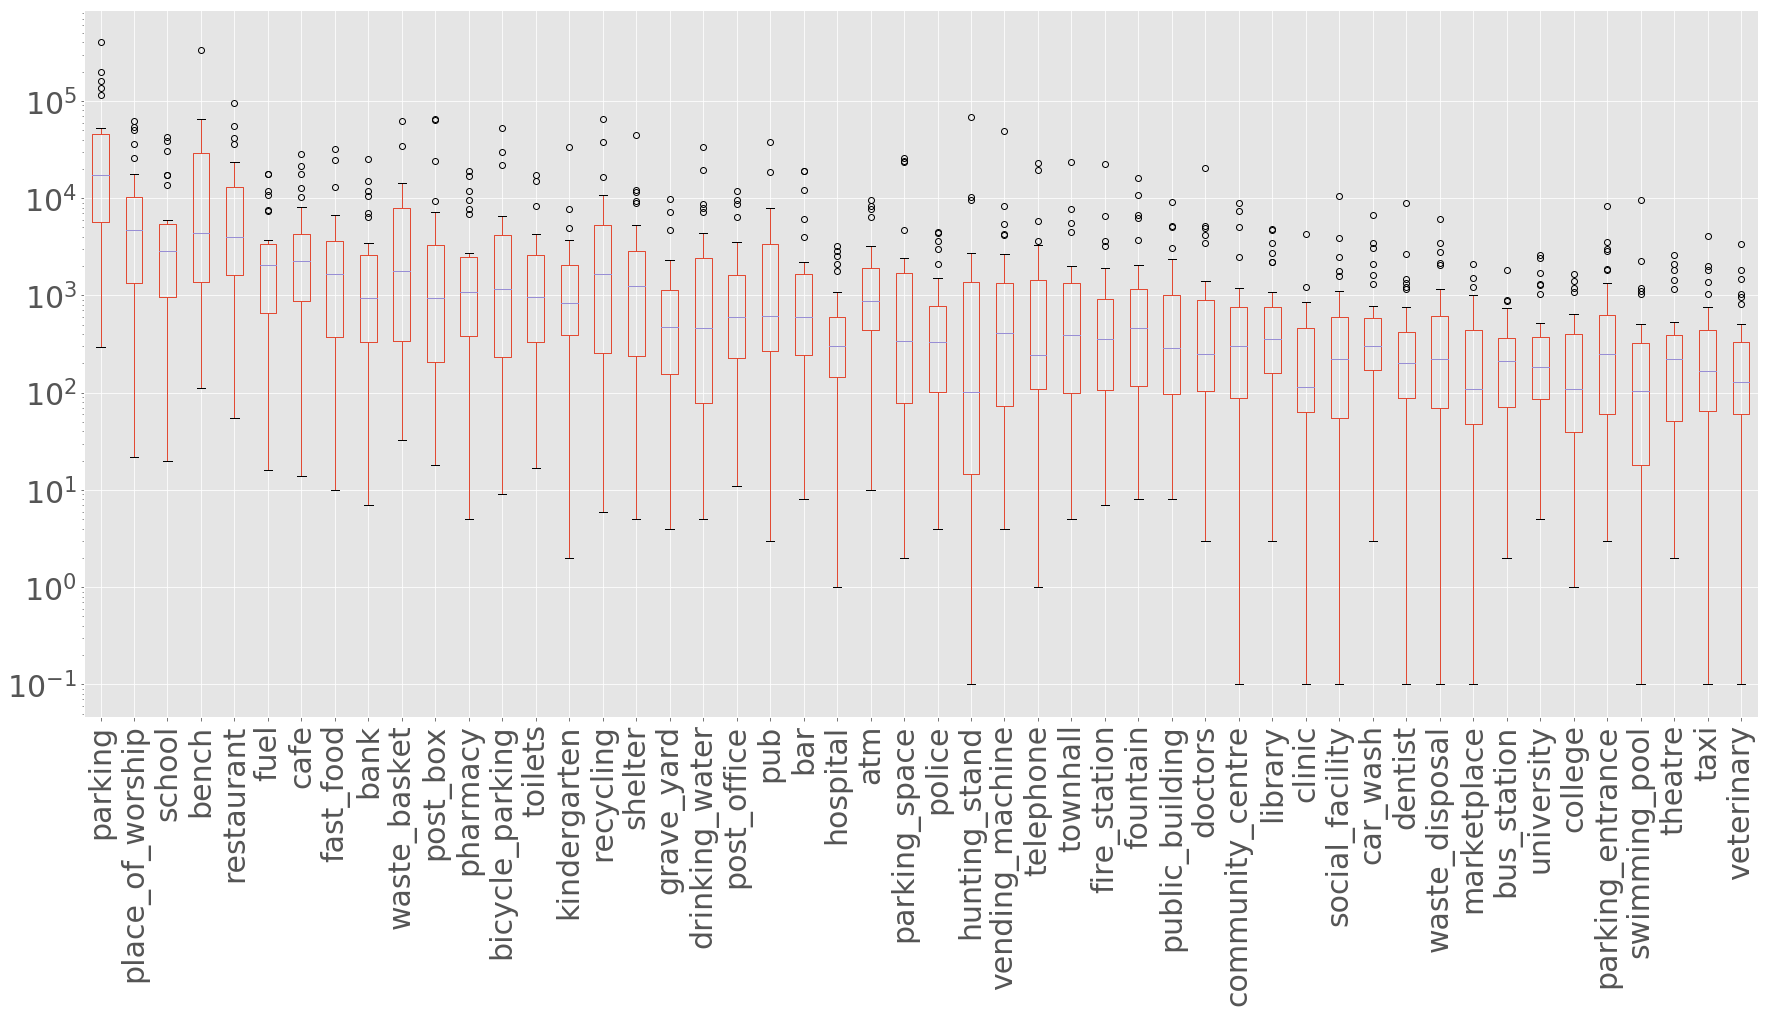

In [5]:
df_amenity.plot(kind='box', figsize=(30, 13), rot=90, logy=True, fontsize=30);

Text(0.5,0,'Bench per Capita')

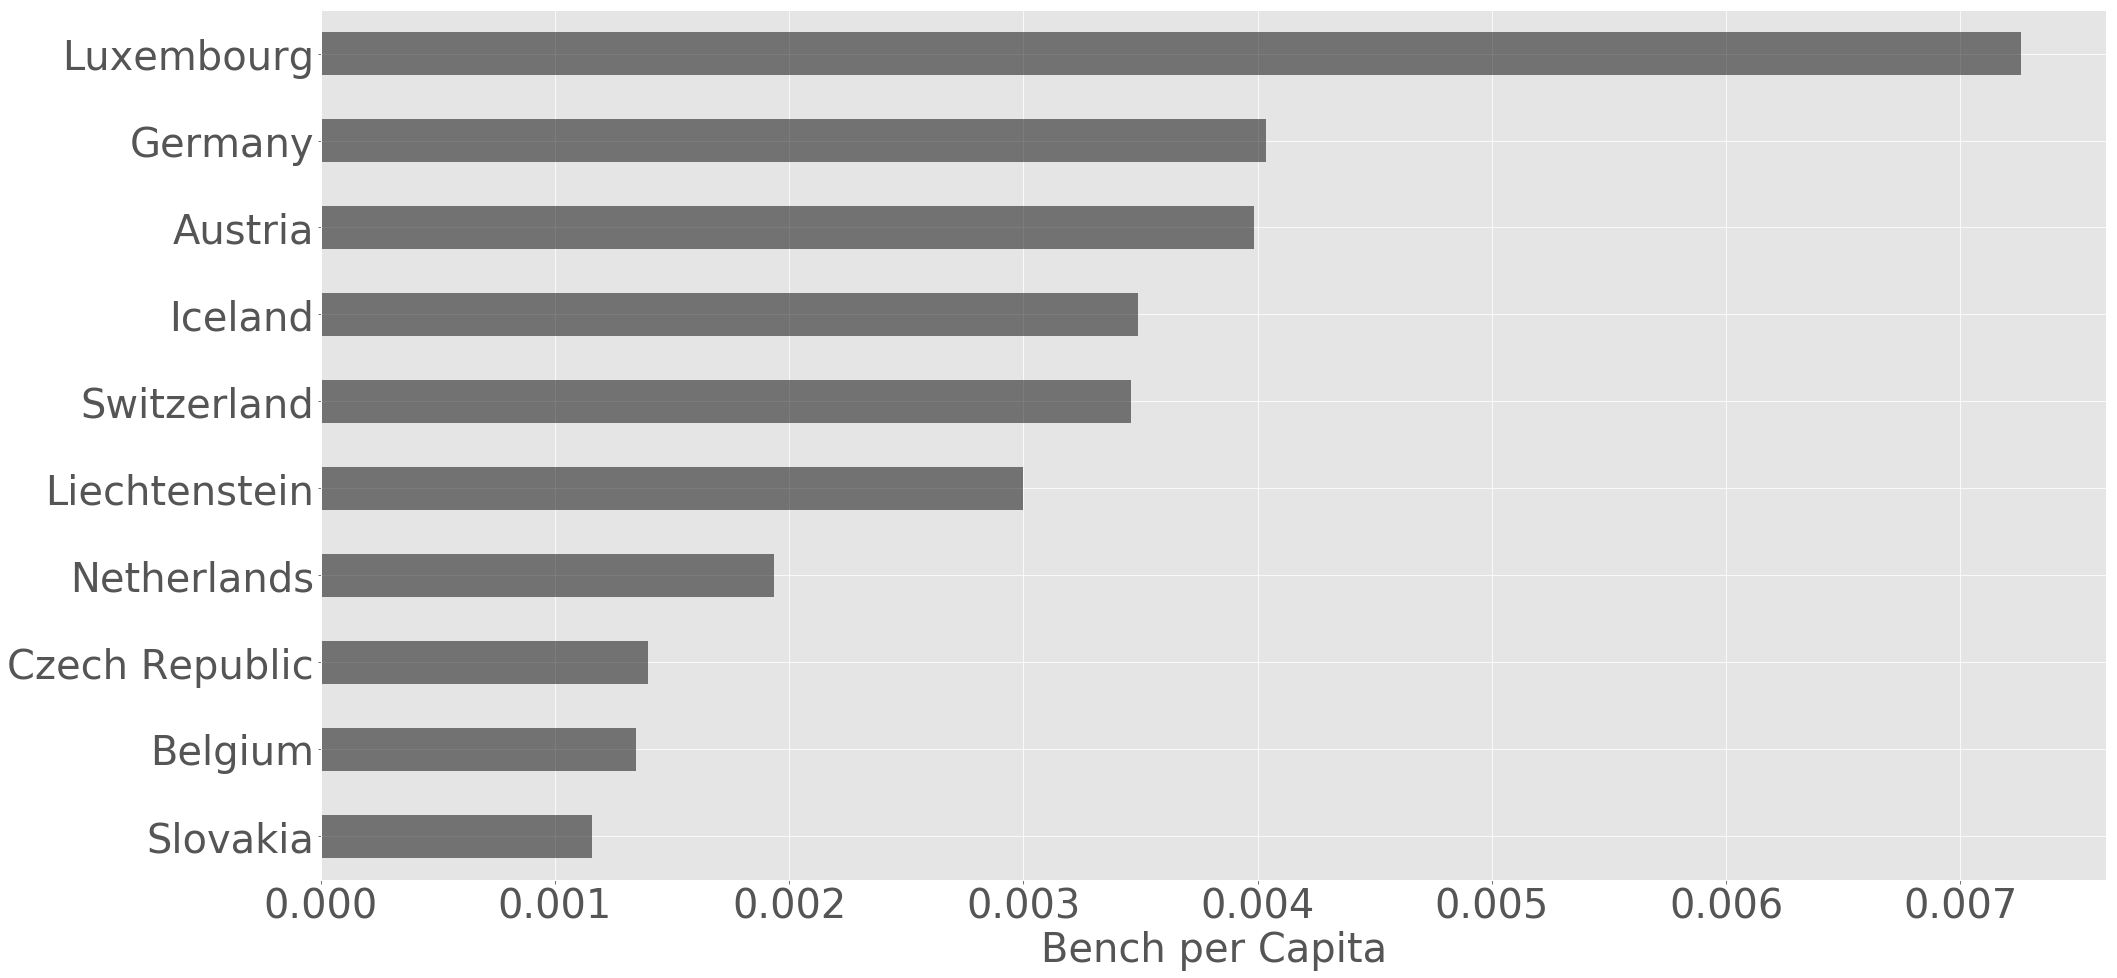

In [6]:
#df_amenity_normalized['restaurant'].sort_values(ascending=True).plot(kind='barh', color='k', alpha=0.5, figsize=(16, 16));
ax = df_amenity_normalized['bench'].sort_values(ascending=True).iloc[-10:].plot(kind='barh', color='k', alpha=0.5, figsize=(32, 16), fontsize=40);
plt.ylabel('');
plt.xlabel('Bench per Capita', fontsize=40)

## Calculate Correlation between Amenities and Economic Values

In [7]:
from scipy.stats import pearsonr

pearsonr(df_amenity['restaurant'], df_targets['Population'])

(0.8986159793010084, 2.945137715870326e-12)

In [8]:
np.corrcoef(df_amenity['restaurant'], df_targets['Population'])

array([[1.        , 0.89861598],
       [0.89861598, 1.        ]])

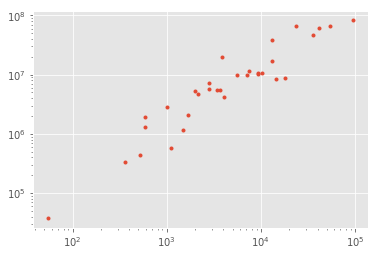

In [9]:
plt.loglog(df_amenity['restaurant'], df_targets['Population'], '.');

In [10]:
correlations = []
for value in df_amenity:
    row = []
    for economic_index in df_targets:
        if economic_index == 'Population':
            df_tmp = pd.concat([df_amenity[value], df_targets[economic_index]], axis=1).dropna()
        else:
            df_tmp = pd.concat([df_amenity_normalized[value], df_targets[economic_index]], axis=1).dropna()
            
        r = pearsonr(df_tmp[value], df_tmp[economic_index])[0]
        #x, y = np.log(df_tmp[value] + 0.00001), np.log(df_tmp[economic_index])
        #r = pearsonr(x, y)[0]
        row.append(r)
    correlations.append(row)
    
df_corr = pd.DataFrame(correlations, index=df_amenity.columns)
df_corr.columns = df_targets.columns
df_corr.head()

,Population,GNI,GDP,BM Dollar,HDI
parking,0.891240,0.685818,0.475158,0.466304,0.535464
place_of_worship,0.970164,0.097026,0.230531,-0.023596,0.101451
school,0.955610,0.750329,0.747299,0.654575,0.716739
bench,0.707870,0.587585,0.739734,0.218858,0.431660
restaurant,0.898616,0.389412,0.512864,0.276159,0.311712


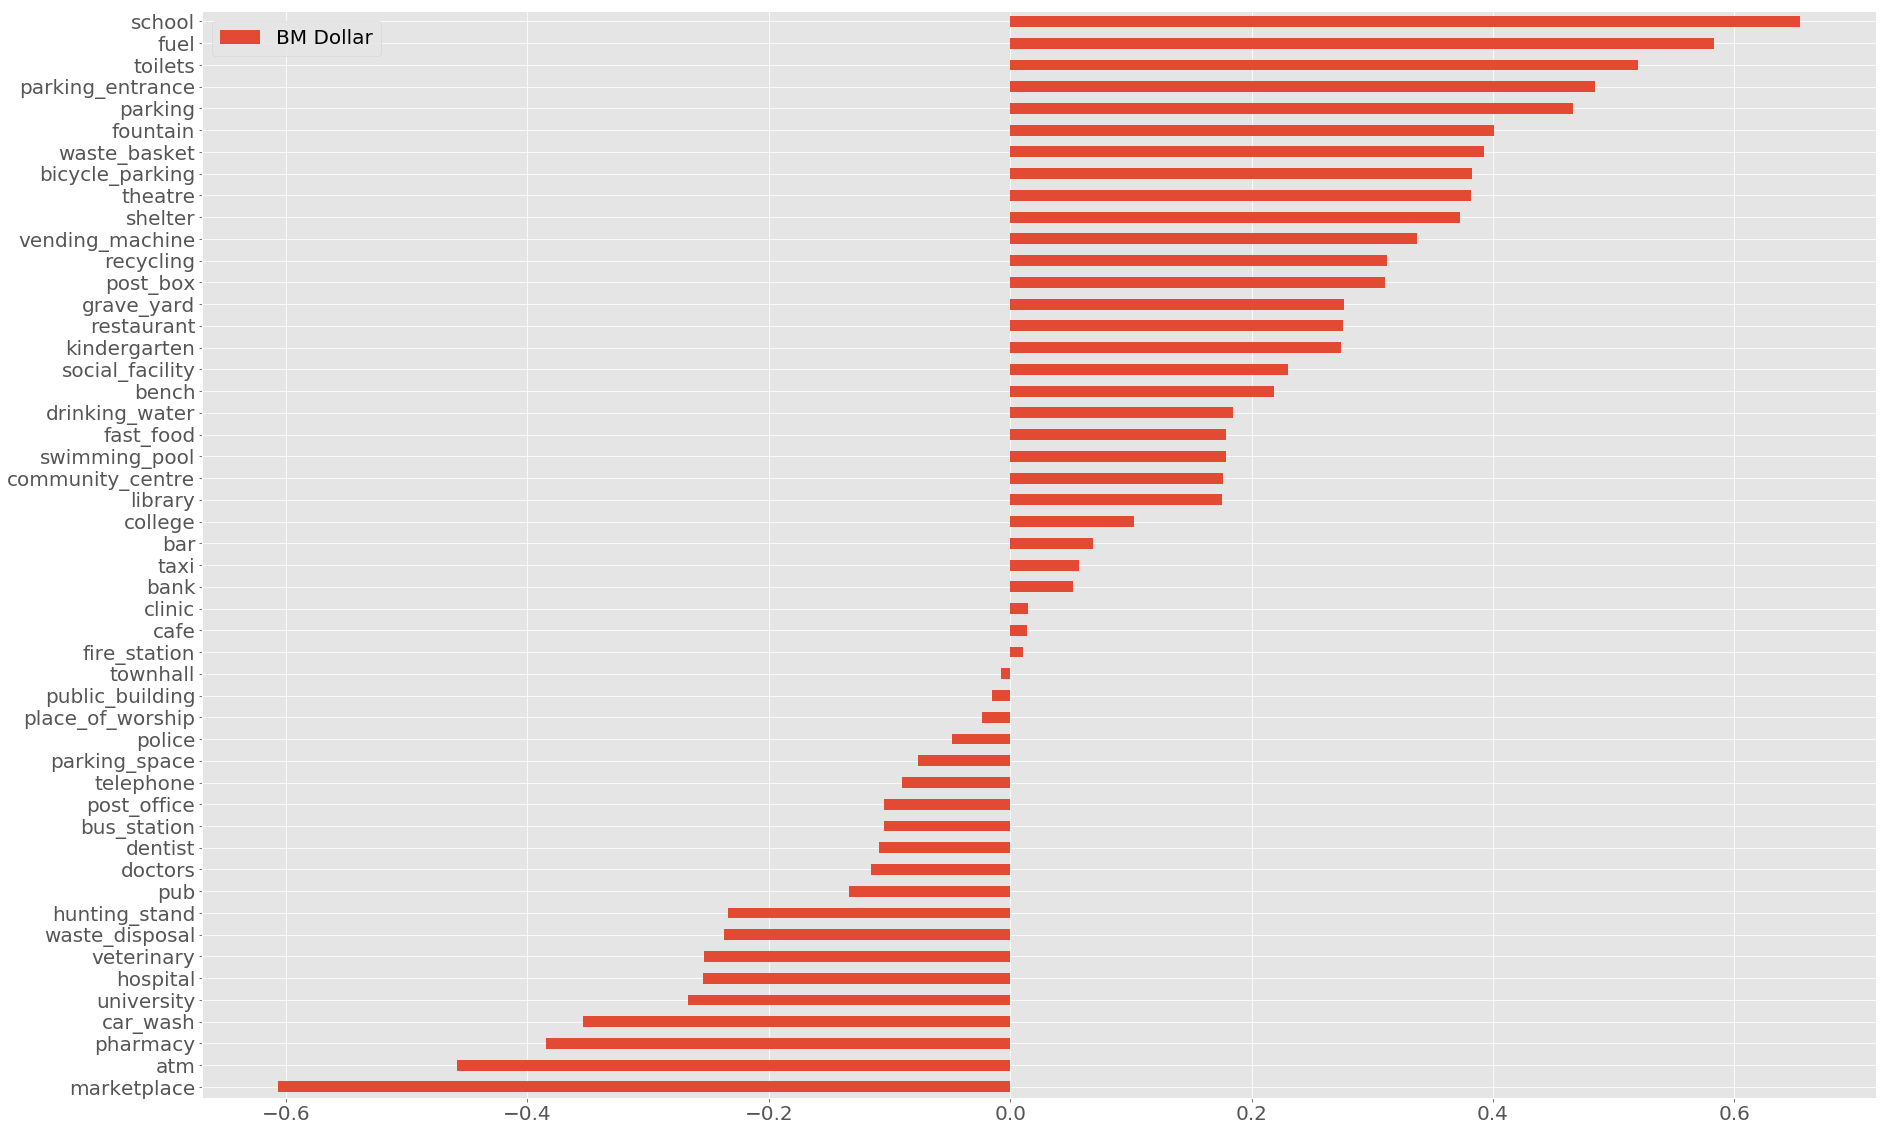

In [11]:
value = 'BM Dollar'
df_corr[[value]].sort_values(by=value).plot(kind='barh', figsize=(30, 20), fontsize=20);
plt.legend(fontsize=20);

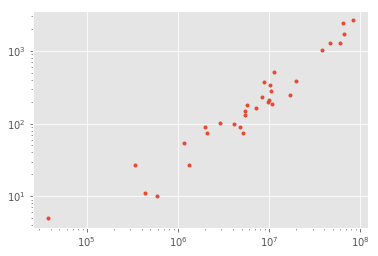

In [12]:
plt.loglog(df_targets['Population'], df_amenity['university'], '.');

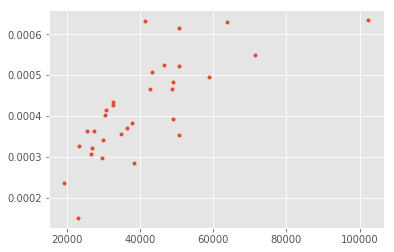

In [13]:
plt.plot(df_targets['GDP'], df_amenity_normalized['school'], '.');

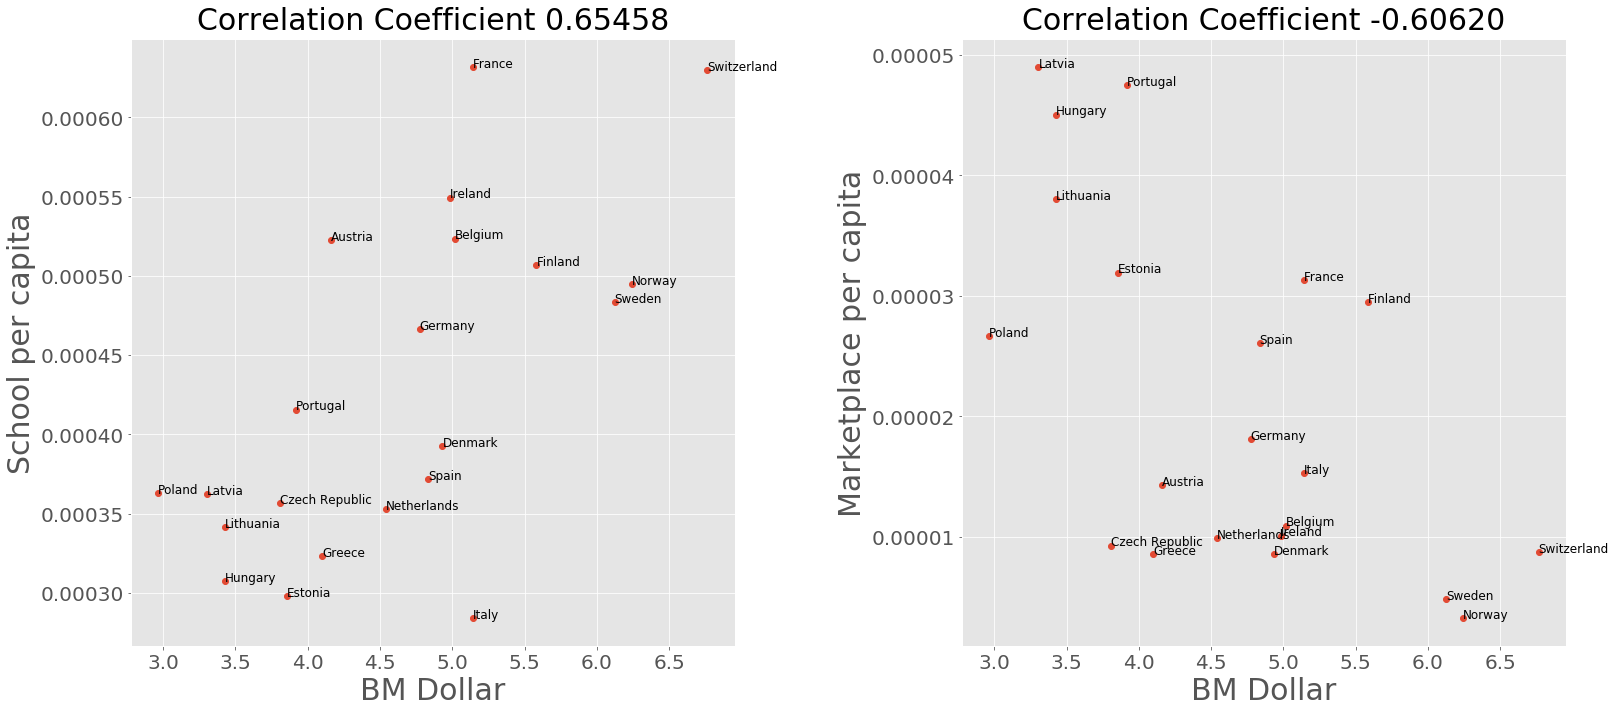

In [14]:
from matplotlib import rcParams
rcParams['axes.titlepad'] = 10 

#measurement, x_offset = 'HDI', 0.001
#measurement, x_offset = 'GDP', 500.0
measurement, x_offset = 'BM Dollar', 0.0
amenity_left, amenity_right = 'school', 'marketplace'
#amenity_left, amenity_right = 'bar', 'fuel'

#measurement, x_offset = 'BM Dollar PPP', 0.0

plt.figure(figsize=(22, 10))
plt.subplot(1, 2, 1)
plt.plot(df_targets[measurement], df_amenity_normalized[amenity_left], 'o')
plt.xticks(fontsize=20)
plt.xlabel(measurement, fontsize=30)
plt.yticks(fontsize=20)
#plt.xlim([0, 20])
plt.ylabel('{} per capita'.format(amenity_left.title()), fontsize=30)
plt.title('Correlation Coefficient {:.5f}'.format(df_corr.loc[amenity_left][measurement]), fontsize=30)
for i, country in enumerate(df_amenity_normalized.index):
    if not np.isnan(df_targets[measurement][i]):
        plt.annotate(country, (df_targets[measurement][i] + x_offset, df_amenity_normalized[amenity_left][i]), fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(df_targets[measurement], df_amenity_normalized[amenity_right], 'o')
plt.xlabel(measurement, fontsize=30)
plt.xticks(fontsize=20)
plt.ylabel('{} per capita'.format(amenity_right.title()), fontsize=30);
plt.yticks(fontsize=20)
#plt.xlim([0, 20])
plt.title('Correlation Coefficient {:.5f}'.format(df_corr.loc[amenity_right][measurement]), fontsize=30)
for i, country in enumerate(df_amenity_normalized.index):
    if not np.isnan(df_targets[measurement][i]):
        plt.annotate(country, (df_targets[measurement][i] + x_offset, df_amenity_normalized[amenity_right][i]), fontsize=12)
        
plt.tight_layout(w_pad=10)

## Manifold Learning Dimensionality Reduction of Amenity Vectors
- [Manifold Learning](http://scikit-learn.org/stable/modules/manifold.html)

### Principal Component Analysis (PCA)

- [In Depth: Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

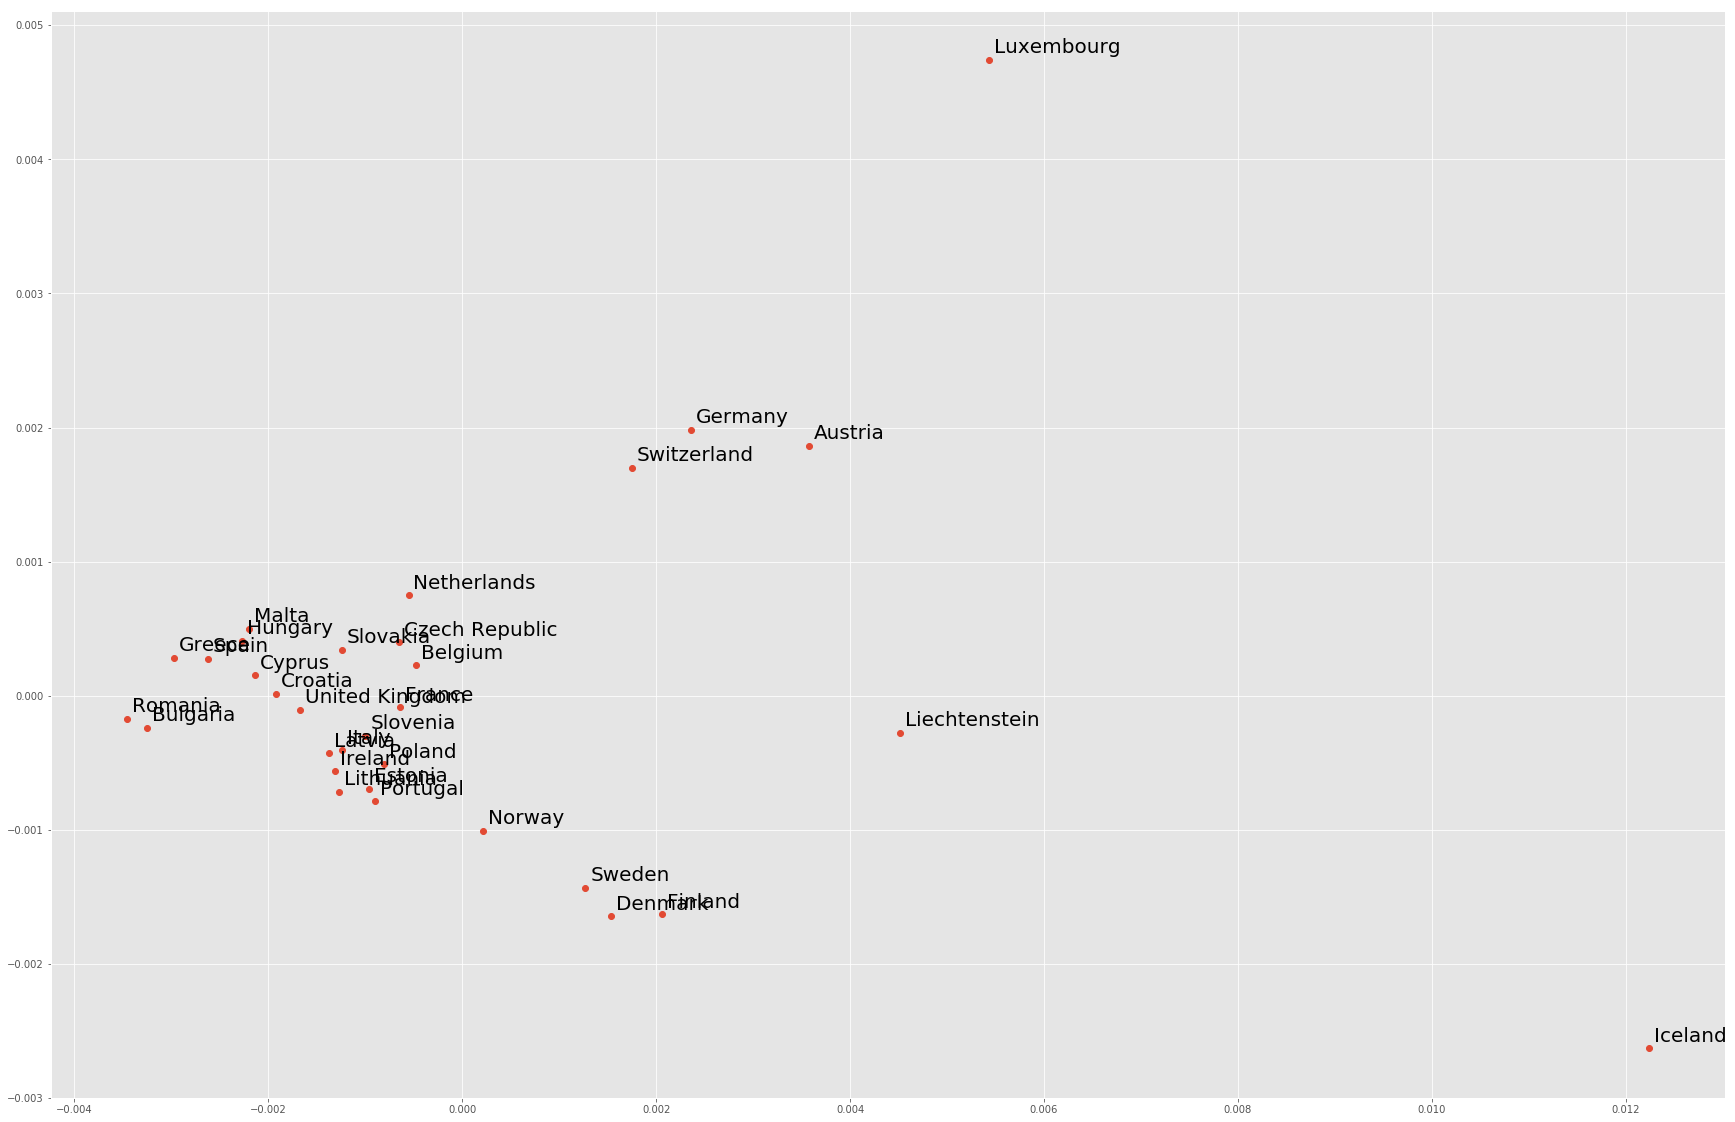

In [43]:
from sklearn.decomposition import PCA

X = df_amenity_normalized.values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(30, 20))
ax.plot(X_pca[:, 0], X_pca[:, 1], 'o')
for i, country in enumerate(df_amenity_normalized.index):
    ax.annotate(country, (X_pca[i, 0] + 0.00005, X_pca[i, 1] + 0.00005), fontsize=20)

### T-distributed Stochastic Neighbor Embedding (T-SNE)

- [How to use t-SNE effectively](https://distill.pub/2016/misread-tsne/)

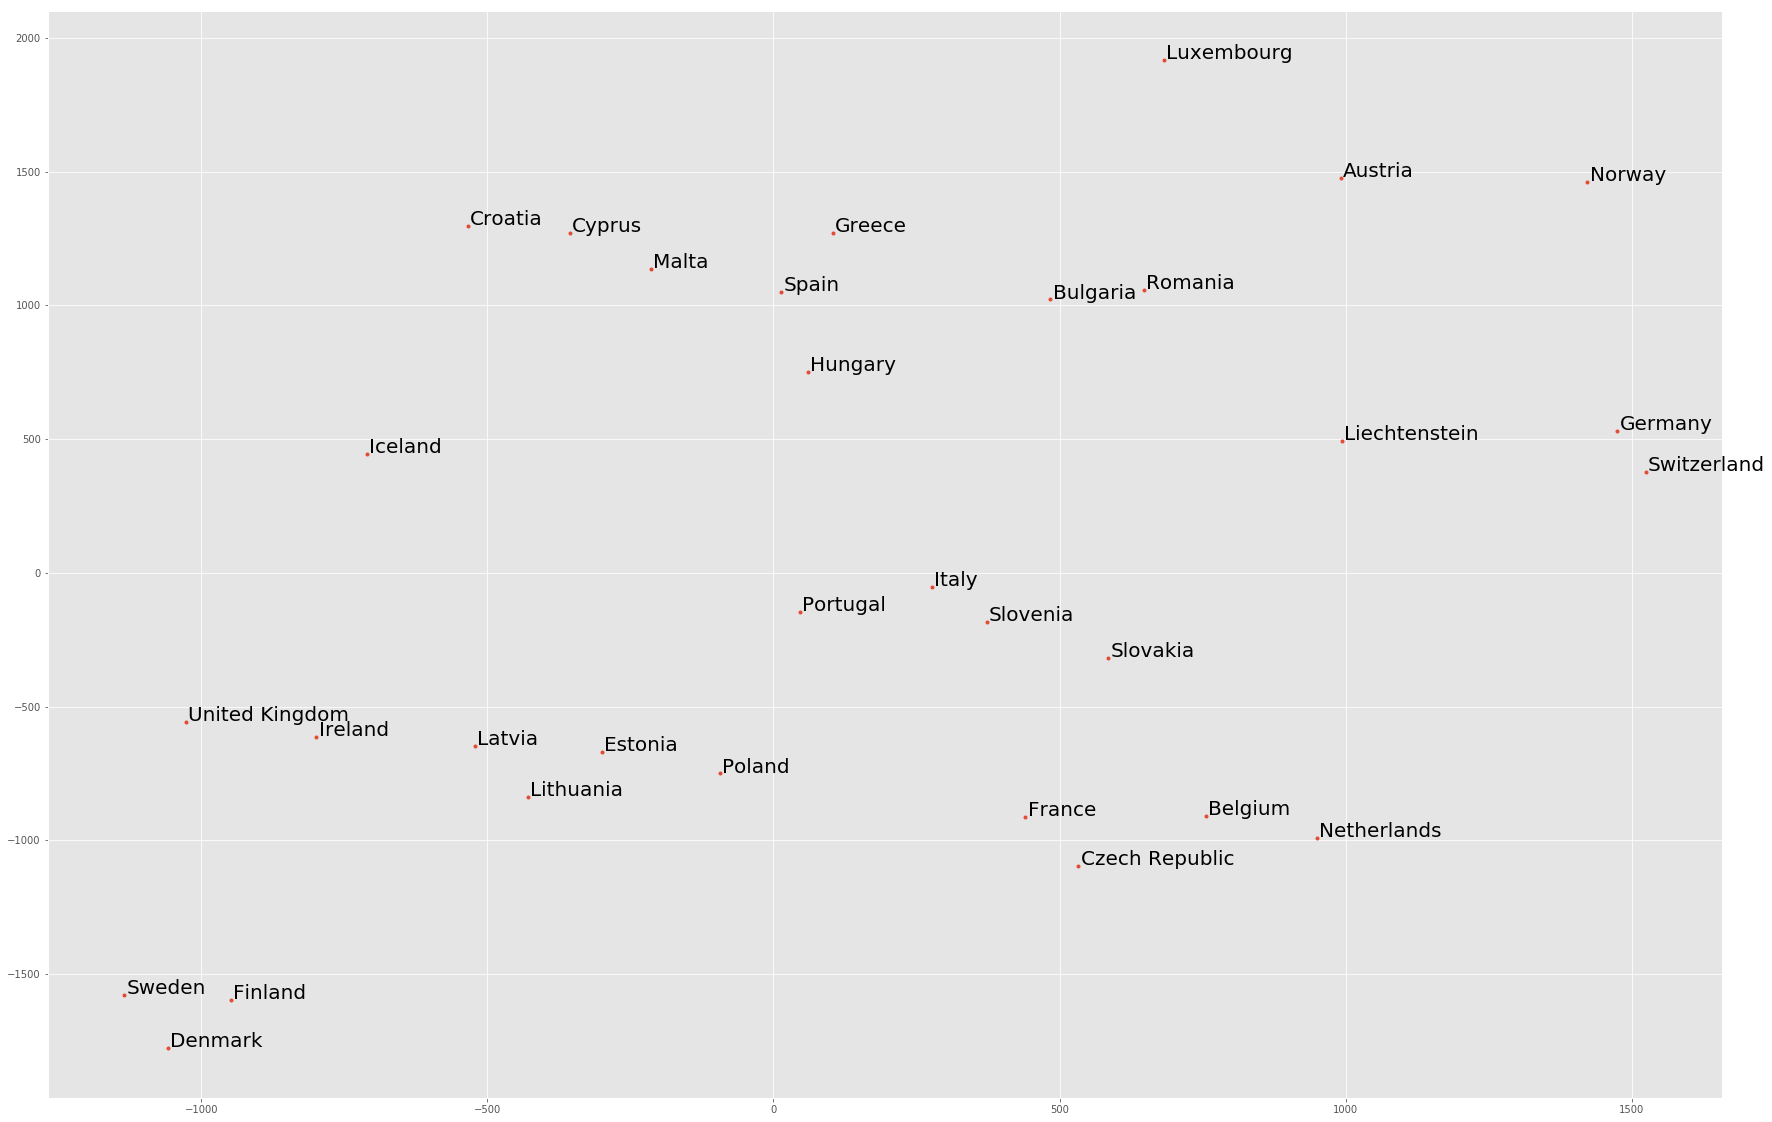

In [44]:
from sklearn.manifold import TSNE

X = df_amenity_normalized.values

tsne = TSNE(n_components=2, learning_rate=1000, perplexity=3)
X_embedded = tsne.fit_transform(X)

fig, ax = plt.subplots(figsize=(30, 20))
ax.plot(X_embedded[:, 0], X_embedded[:, 1], '.')
for i, country in enumerate(df_amenity_normalized.index):
    ax.annotate(country, (X_embedded[i, 0] + 4, X_embedded[i, 1] + 4), fontsize=20)

### Multidimensional Scaling (MDS)

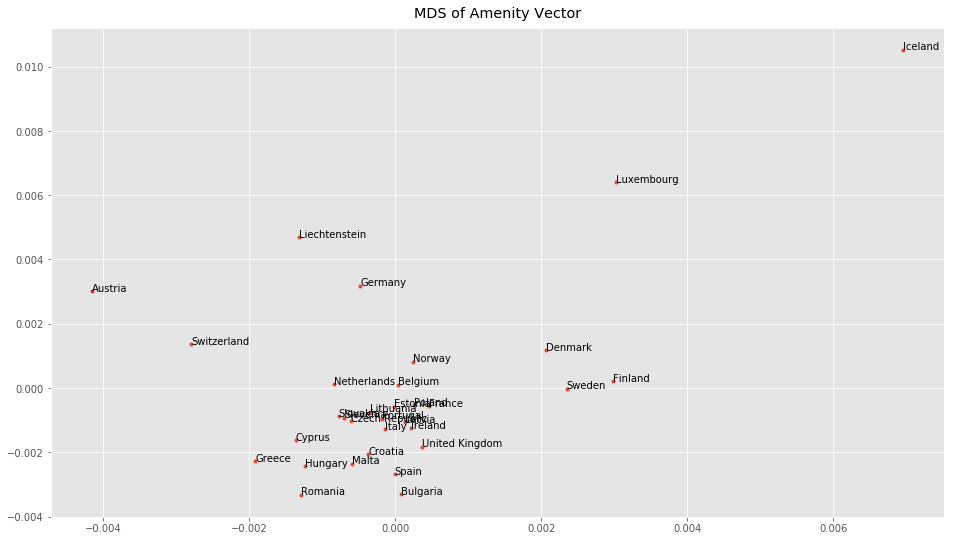

In [42]:
from sklearn.manifold import MDS

mds = MDS(n_components=2)
X_mds = mds.fit_transform(X)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(X_mds[:, 0], X_mds[:, 1], '.')
ax.set_title('MDS of Amenity Vector')

for i, country in enumerate(df_amenity_normalized.index):
    ax.annotate(country, (X_mds[i, 0], X_mds[i, 1]))

### Isomap Embedding

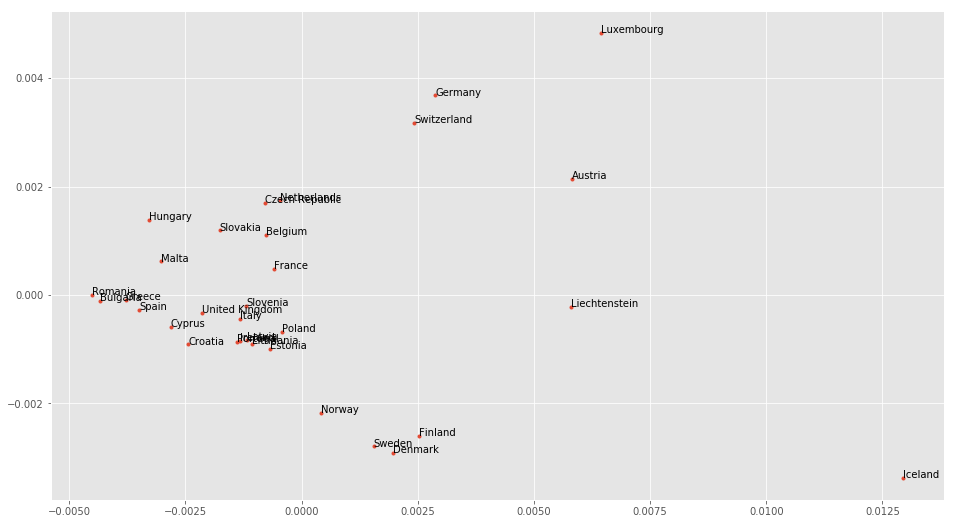

In [45]:
from sklearn.manifold import Isomap

X = df_amenity_normalized.values

isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(X_isomap[:, 0], X_isomap[:, 1], '.')
for i, country in enumerate(df_amenity_normalized.index):
    ax.annotate(country, (X_isomap[i, 0], X_isomap[i, 1]))

### Spectral Embedding for non-linear Dimensionality Reduction

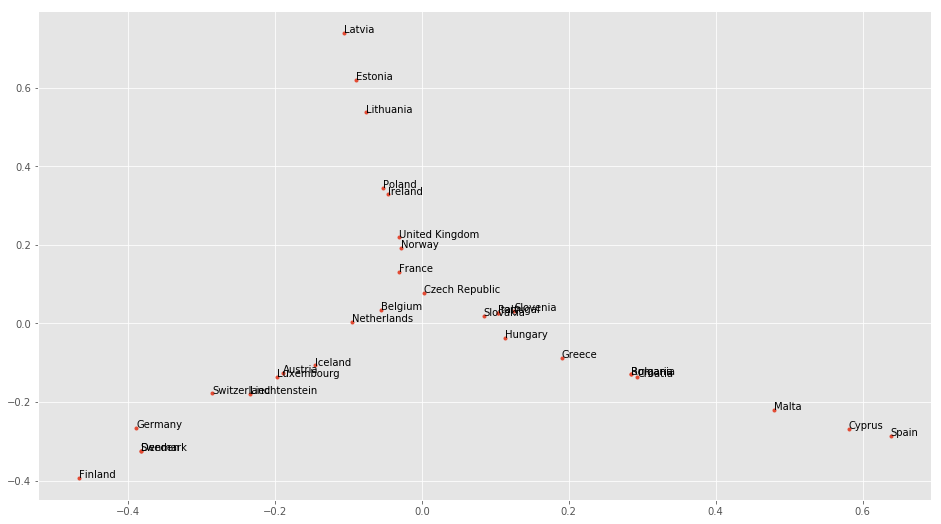

In [47]:
from sklearn.manifold import SpectralEmbedding

X = df_amenity_normalized.values

spectral_embedding = SpectralEmbedding(n_components=2)
X_spectral_embedding = spectral_embedding.fit_transform(X)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(X_spectral_embedding[:, 0], X_spectral_embedding[:, 1], '.')
for i, country in enumerate(df_amenity_normalized.index):
    ax.annotate(country, (X_spectral_embedding[i, 0], X_spectral_embedding[i, 1]))

# Linear Regression
- [In Depth: Linear Regression](https://github.com/jakevdp/PythonDataScienceHandbook/blob/599aa0fe3f882c0001670e676e5a8d43b92c35fc/notebooks/05.06-Linear-Regression.ipynb)
- [Scikit-learn cross validation scoring for regression](https://stackoverflow.com/questions/24132237/scikit-learn-cross-validation-scoring-for-regression)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score

In [22]:
df_amenity_normalized.describe()

,parking,place_of_worship,school,bench,restaurant,fuel,cafe,fast_food,bank,waste_basket,...,waste_disposal,marketplace,bus_station,university,college,parking_entrance,swimming_pool,theatre,taxi,veterinary
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,3.200000e+01,32.000000,32.000000,32.000000,32.000000,32.000000,3.200000e+01,32.000000,32.000000,32.000000
mean,0.003527,0.000655,0.000425,0.001392,0.000824,0.000279,0.000358,0.000263,0.000178,0.000535,...,4.960142e-05,0.000020,0.000030,0.000033,0.000019,0.000056,2.379066e-05,0.000029,0.000030,0.000023
std,0.002813,0.000283,0.000119,0.001548,0.000467,0.000121,0.000188,0.000217,0.000086,0.000841,...,4.778247e-05,0.000014,0.000015,0.000022,0.000010,0.000067,3.061376e-05,0.000009,0.000019,0.000012
min,0.000483,0.000236,0.000151,0.000052,0.000197,0.000109,0.000047,0.000050,0.000070,0.000010,...,2.286143e-07,0.000002,0.000007,0.000014,0.000003,0.000003,2.105362e-08,0.000011,0.000003,0.000003
25%,0.001994,0.000465,0.000350,0.000626,0.000448,0.000205,0.000240,0.000143,0.000121,0.000139,...,1.056210e-05,0.000009,0.000019,0.000021,0.000012,0.000019,6.290023e-06,0.000023,0.000015,0.000014
50%,0.002822,0.000607,0.000409,0.000724,0.000742,0.000259,0.000328,0.000196,0.000157,0.000228,...,3.373191e-05,0.000015,0.000029,0.000027,0.000019,0.000036,1.486520e-05,0.000030,0.000027,0.000022
75%,0.004554,0.000805,0.000511,0.001358,0.001000,0.000316,0.000437,0.000317,0.000224,0.000661,...,6.821704e-05,0.000030,0.000037,0.000036,0.000024,0.000056,2.671283e-05,0.000033,0.000043,0.000027
max,0.015308,0.001316,0.000634,0.007261,0.002045,0.000754,0.000897,0.001184,0.000398,0.003876,...,2.027194e-04,0.000049,0.000076,0.000133,0.000046,0.000345,1.448599e-04,0.000053,0.000081,0.000058


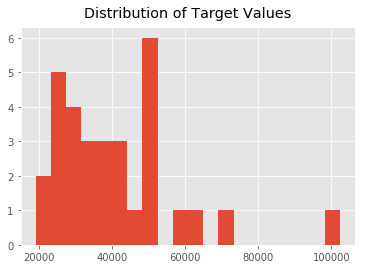

In [57]:
gdp = df_targets['GDP']

df_X = df_amenity_normalized[gdp.notna()]
df_y = gdp[gdp.notna()]

plt.hist(df_y, bins=20);
plt.title('Distribution of Target Values');

In [60]:
#pca = PCA(n_components=10)
#X = pca.fit_transform(df_X)
X = df_X.values

reg = LinearRegression()
scores = cross_val_score(reg, X, df_y, 
                         scoring='neg_mean_squared_error', 
                         cv=LeaveOneOut())

print(scores)
print('RMSE : {}'.format(np.sqrt(-scores.mean())))
print('Std of errors  : {}'.format(scores.std()))

[-1.66534207e+08 -4.87745515e+07 -6.33791009e+07 -1.28835174e+08
 -1.63207829e+08 -1.52484749e+04 -4.51254214e+05 -1.99623569e+08
 -3.08147187e+05 -9.26009634e+07 -5.95933859e+07 -1.75362339e+08
 -5.21635383e+07 -1.50393351e+06 -6.62188901e+02 -6.61240485e+08
 -1.22851164e+06 -4.72798795e+07 -1.66516978e+07 -3.48763991e+09
 -4.13374510e+06 -4.92451030e+07 -7.23767947e+06 -2.36549471e+07
 -1.33822288e+07 -4.81132446e+07 -2.43952457e+08 -7.33331508e+07
 -3.53771203e+09 -2.97109796e+08 -1.74396998e+08]
RMSE : 17815.05866045528
Std of errors  : 849063537.6109098


### Mean Squared Error for various number of Feature Dimensions

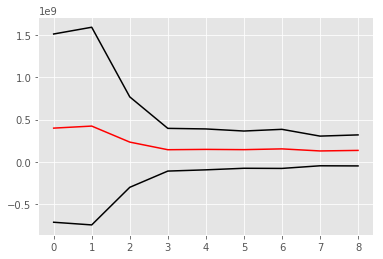

In [62]:
#pca = PCA(n_components=20)
#X = pca.fit_transform(df_X)
X = df_X.values

#n = X.shape[1]
n = 10
scores = [cross_val_score(reg, X[:, :i], df_y, scoring='neg_mean_squared_error', cv=LeaveOneOut())
          for i in range(1, n)]

results = np.array([(-score.mean(), score.std()) for score in scores])

plt.plot(results[:, 0], 'r');
plt.plot(results[:, 0] + results[:, 1], 'k');
plt.plot(results[:, 0] - results[:, 1], 'k');

## Other Regression Methods

- [Generalized Linear Models](http://scikit-learn.org/stable/modules/linear_model.html)
- [Support Vector Regression (SVR) using linear and non-linear kernels](http://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html)

### Ridge Regression

- [sklearn.linear_model.Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- [sklearn.linear_model.RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

In [31]:
from sklearn.linear_model import Ridge, RidgeCV

#pca = PCA(n_components=20)
#X = pca.fit_transform(df_X)
X = df_X.values

reg = Ridge(alpha=1.0)
reg.fit(X, df_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [32]:
scores = cross_val_score(reg, X, df_y, scoring='neg_mean_squared_error', cv=LeaveOneOut())

print(scores)
print('RMSE : {}'.format(np.sqrt(-scores.mean())))
print('Std of errors  : {}'.format(scores.std()))

[-3.01246168e+07 -5.10810814e+08 -4.32972883e+07 -6.68210009e+07
 -6.39745873e+07 -1.38113348e+08 -9.83958128e+08 -2.19464972e+08
 -2.47077952e+07 -5.47527944e+04 -3.34273151e+08 -7.99322377e+06
 -7.54810045e+07 -2.57485696e+08 -1.35232173e+08 -4.00832576e+09
 -2.21871486e+08 -1.08474390e+07 -9.47788818e+07 -9.49661373e+07
 -2.01387593e+08 -1.16777391e+08 -3.49320656e+08 -7.52236101e+07
 -1.21248430e+08 -5.45052321e+06 -6.47374267e+07 -2.53320133e+06
 -9.88097949e+07 -3.33494479e+08 -5.53582084e+08]
RMSE : 17269.35328645719
Std of errors  : 707459224.5942796


In [33]:
reg = RidgeCV()
reg.fit(X, df_y)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [34]:
scores = cross_val_score(reg, X, df_y, scoring='neg_mean_squared_error', cv=LeaveOneOut())

print(scores)
print('RMSE : {}'.format(np.sqrt(-scores.mean())))
print('Std of errors  : {}'.format(scores.std()))

[-3.01446276e+07 -5.09699720e+08 -4.32594866e+07 -6.66750251e+07
 -6.35600318e+07 -1.37910422e+08 -9.84695232e+08 -2.18817824e+08
 -2.45121032e+07 -5.68660398e+04 -3.33747018e+08 -7.93409553e+06
 -7.52018601e+07 -2.57126983e+08 -1.34973147e+08 -4.00472025e+09
 -2.21397223e+08 -1.07446533e+07 -9.48006686e+07 -9.43301612e+07
 -2.01191999e+08 -1.16590710e+08 -3.48341601e+08 -7.50816758e+07
 -1.21072492e+08 -5.38616860e+06 -6.46160804e+07 -2.57394096e+06
 -9.72105965e+07 -3.33497519e+08 -5.52684828e+08]
RMSE : 17257.588335995853
Std of errors  : 706896808.0550693


### Lasso Regression

In [63]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

X = df_X.values

reg = Lasso(alpha=1.0)
reg.fit(X, df_y)
scores = cross_val_score(reg, X, df_y, scoring='neg_mean_squared_error', cv=LeaveOneOut())

print('RMSE Lasso     : {}'.format(np.sqrt(-scores.mean())))
print('Std of errors  : {}'.format(scores.std()))

reg = LassoCV()
reg.fit(X, df_y)
scores = cross_val_score(reg, X, df_y, scoring='neg_mean_squared_error', cv=LeaveOneOut())

print('RMSE LassoCV   : {}'.format(np.sqrt(-scores.mean())))
print('Std of errors  : {}'.format(scores.std()))

RMSE Lasso     : 17661.262303660344
Std of errors  : 801423589.146827
RMSE LassoCV   : 18579.634274769764
Std of errors  : 837671032.915646
